In [1]:
# Mutation Simulation experiments for a variety of genomes

# Author Fraser Toon

In [2]:
# Imports needed
import os
import subprocess
import helpers
import pandas
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
import numpy

In [3]:
# Number of genomes for the test: 540
# Filters are:
# Type: Bacteria
# Length: Complete
# Year: 2023-2024
# Condition (?): Referenced and Annotated

In [4]:
# Specify the starting directory
start_directory = '/home/ftoon/Tests/TestingDatasets/ncbi_dataset/data'

# Arrays to hold directories and file names
directories = []
file_names = []

# Traverse the directory tree
for root, dirs, files in os.walk(start_directory):
    for file in files:
        if file.endswith('genomic.fna') and "SNP" not in file:
            directories.append(root)
            file_names.append(file)

print(f"Done: {len(directories), len(file_names)}")


Done: (540, 540)


In [8]:
index = 0
rate = [0.05]
for SNP_rate in rate:
    if directories and file_names:
        for first_directory, first_fna_file in zip(directories, file_names):
            index = index + 1
            print(f'{index}: {first_directory} -> {first_fna_file}')

            # Build the command to change directory and show the first 10 lines of the .fna fil
            command = f'cd {first_directory} && (/usr/bin/time -v mutation-simulator {first_fna_file} args -sn {SNP_rate} && mv $(find . -name "*.fna" | grep -vi "_gen" | grep -vi "SNP") SNP_{SNP_rate}_{first_fna_file} && mv $(find . -name "*.fna.fai" | grep -vi "SNP") SNP_{SNP_rate}_{first_fna_file}.fai)  > stats.txt 2>&1'

            try:
                # Run the command in the shell with a timeout of 3 minutes
                result = subprocess.run(command, shell=True, timeout=3*60, stderr=subprocess.PIPE, universal_newlines=True)

                # Print stderr output
                if result.stderr:
                    print(result.stderr)
                
            except subprocess.TimeoutExpired as e:
                print(f"Command timed out: {e}")
            except Exception as e:
                print(f"An error occurred: {e}")
    else:
        print("No .fna files found.")
print("Done")

1: /home/ftoon/Tests/TestingDatasets/ncbi_dataset/data/GCF_032850805.1 -> GCF_032850805.1_ASM3285080v1_genomic.fna
2: /home/ftoon/Tests/TestingDatasets/ncbi_dataset/data/GCF_028885435.1 -> GCF_028885435.1_ASM2888543v1_genomic.fna
3: /home/ftoon/Tests/TestingDatasets/ncbi_dataset/data/GCF_036352135.1 -> GCF_036352135.1_ASM3635213v1_genomic.fna
4: /home/ftoon/Tests/TestingDatasets/ncbi_dataset/data/GCF_028877475.1 -> GCF_028877475.1_ASM2887747v1_genomic.fna
5: /home/ftoon/Tests/TestingDatasets/ncbi_dataset/data/GCF_028609865.1 -> GCF_028609865.1_ASM2860986v1_genomic.fna
6: /home/ftoon/Tests/TestingDatasets/ncbi_dataset/data/GCF_964019765.1 -> GCF_964019765.1_ijPanGerm4.Spiroplasma_sp_1.1_genomic.fna
7: /home/ftoon/Tests/TestingDatasets/ncbi_dataset/data/GCF_029892045.1 -> GCF_029892045.1_ASM2989204v1_genomic.fna
8: /home/ftoon/Tests/TestingDatasets/ncbi_dataset/data/GCF_029714545.1 -> GCF_029714545.1_ASM2971454v1_genomic.fna
9: /home/ftoon/Tests/TestingDatasets/ncbi_dataset/data/GCF_0302

In [5]:
# Make full path of original files
index = 0
original_genomes = []
if directories and file_names:
    for first_directory, first_fna_file in zip(directories, file_names):
        file_location = first_directory + "/" + first_fna_file
        original_genomes.append(file_location)
        index = index + 1

else:
    print("No .fna files found.")

print(f"Done: {len(original_genomes)}")
print(f"{original_genomes[0]}")

Done: 540
/home/ftoon/Tests/TestingDatasets/ncbi_dataset/data/GCF_032850805.1/GCF_032850805.1_ASM3285080v1_genomic.fna


In [6]:
# Get paths of new genomes
# See if there has been a 5% change in each, get length of orginal, length of change and difference value between them.ls
new_genomes = []
end_pattern = ".fna"
mod_patterns = ["0.05"]
bad_pattern = ".fai"

# Traverse the directory tree
for root, dirs, files in os.walk(start_directory):
    for file in files:
        if end_pattern in file and any(mod_pattern in file for mod_pattern in mod_patterns) and bad_pattern not in file:
            new_genomes.append(str(root) + "/" + str(file))


print(f"Done: {len(new_genomes)}")
print(f"{new_genomes[0]}")

Done: 540
/home/ftoon/Tests/TestingDatasets/ncbi_dataset/data/GCF_032850805.1/SNP_0.05_GCF_032850805.1_ASM3285080v1_genomic.fna


In [7]:
time_array = []
max_resident_size_array = []

for file_path in directories:
    if not os.path.isfile(file_path + "/stats.txt"):
        print(f"The file at {file_path} does not exist.")
        continue

    try:
        with open(file_path + "/stats.txt", 'r') as file:
            found_time = False
            found_max_res = False

            for line in file:
                if not found_time:
                    time_match = re.search(r'Mutation-Simulator finished in: ([\d.]+)s', line)
                    if time_match:
                        time_taken = time_match.group(1)
                        time_array.append(float(time_taken))
                        found_time = True

                if not found_max_res:
                    max_res_match = re.search(r'Maximum resident set size \(kbytes\): (\d+)', line)
                    if max_res_match:
                        max_resident_size = max_res_match.group(1)
                        max_resident_size_array.append(int(max_resident_size))
                        found_max_res = True

                if found_time and found_max_res:
                    break

            if not found_time:
                print(f"No simulation time found in the file: {file_path}")
            if not found_max_res:
                print(f"No maximum resident set size found in the file: {file_path}")
                
    except Exception as e:
        print(f"An error occurred while processing the file {file_path}: {e}")

print(f"Time array: {len(time_array)}")
print(f"Maximum resident size array: {len(max_resident_size_array)}")

print(f"T: {time_array[0]}, M: {max_resident_size_array[0]}")

Time array: 540
Maximum resident size array: 540
T: 4.4183, M: 100348


In [8]:
# Array to hold file sizes
file_sizes = []

for file_path in original_genomes:
    try:
        # Get the file size
        file_size = os.path.getsize(file_path)
        # Append the file size to the array
        file_sizes.append(file_size)
    except OSError as e:
        # If there's an error (e.g., file doesn't exist), append None and print an error message
        file_sizes.append(None)
        print(f"Error accessing file {file_path}: {e}")

# Print the array with file sizes
print("File sizes:", len(file_sizes))

File sizes: 540


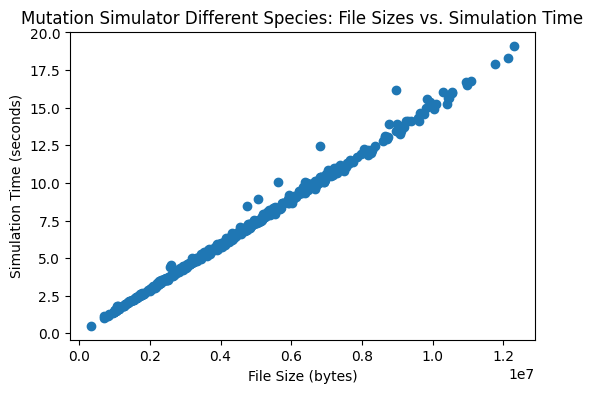

In [9]:
# Plotting time against genome size
# Convert file paths to a simple numeric index for x-axis
x = file_sizes
y = time_array

plt.figure(figsize=(6, 4))  # Set the figure size (width, height)
plt.scatter(x, y)
plt.title('Mutation Simulator Different Species: File Sizes vs. Simulation Time')
plt.xlabel('File Size (bytes)')
plt.ylabel('Simulation Time (seconds)')
#plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
plt.show()

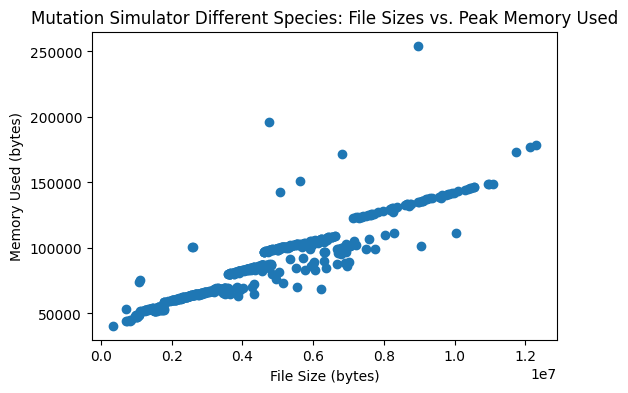

In [10]:
# Plotting memory against genome size
# Convert file paths to a simple numeric index for x-axis
x = file_sizes
y = max_resident_size_array

plt.figure(figsize=(6, 4))  # Set the figure size (width, height)
plt.scatter(x, y)
plt.title('Mutation Simulator Different Species: File Sizes vs. Peak Memory Used')
plt.xlabel('File Size (bytes)')
plt.ylabel('Memory Used (bytes)')
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
plt.show()

OG: /home/ftoon/Tests/TestingDatasets/ncbi_dataset/data/GCF_032850805.1/GCF_032850805.1_ASM3285080v1_genomic.fna
NG: /home/ftoon/Tests/TestingDatasets/ncbi_dataset/data/GCF_032850805.1/SNP_0.05_GCF_032850805.1_ASM3285080v1_genomic.fna
Genome size: 2544243
Percent Difference: 0.05
Differences found: [15, 29, 79, 124, 127, 129, 181, 189]


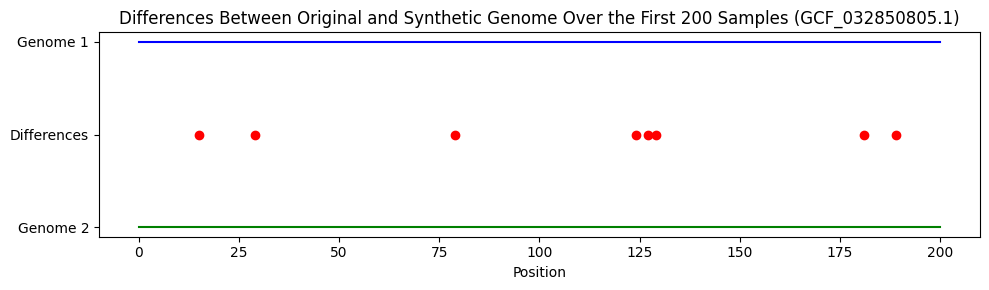

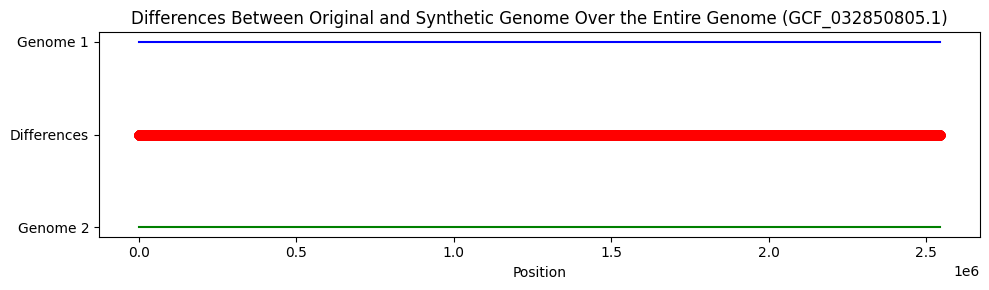

OG: /home/ftoon/Tests/TestingDatasets/ncbi_dataset/data/GCF_028885435.1/GCF_028885435.1_ASM2888543v1_genomic.fna
NG: /home/ftoon/Tests/TestingDatasets/ncbi_dataset/data/GCF_028885435.1/SNP_0.05_GCF_028885435.1_ASM2888543v1_genomic.fna
Genome size: 1081520
Percent Difference: 0.05
Differences found: [37, 49, 96, 99, 138, 173]


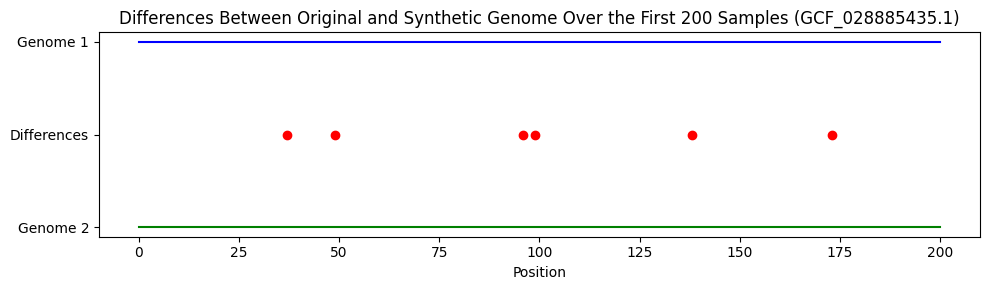

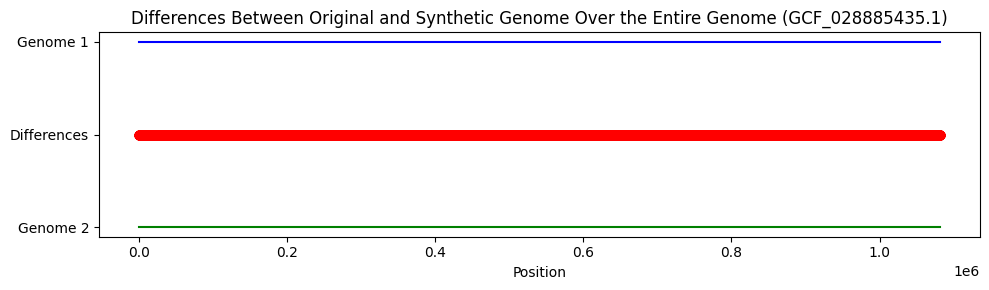

OG: /home/ftoon/Tests/TestingDatasets/ncbi_dataset/data/GCF_036352135.1/GCF_036352135.1_ASM3635213v1_genomic.fna
NG: /home/ftoon/Tests/TestingDatasets/ncbi_dataset/data/GCF_036352135.1/SNP_0.05_GCF_036352135.1_ASM3635213v1_genomic.fna
Genome size: 689432
Percent Difference: 0.05
Differences found: [11, 37, 66, 81, 109, 125, 176, 179, 181, 183, 188]


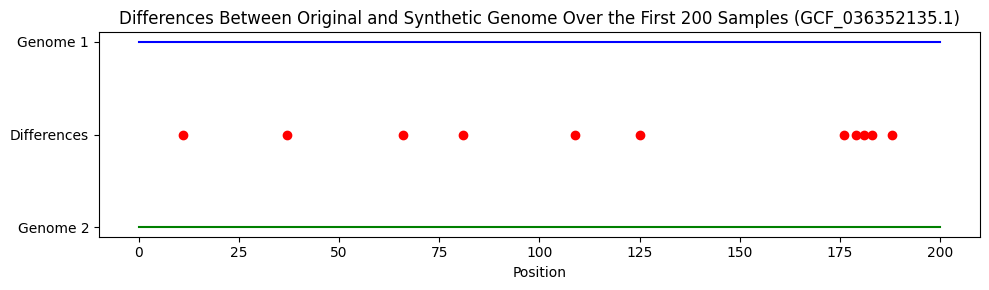

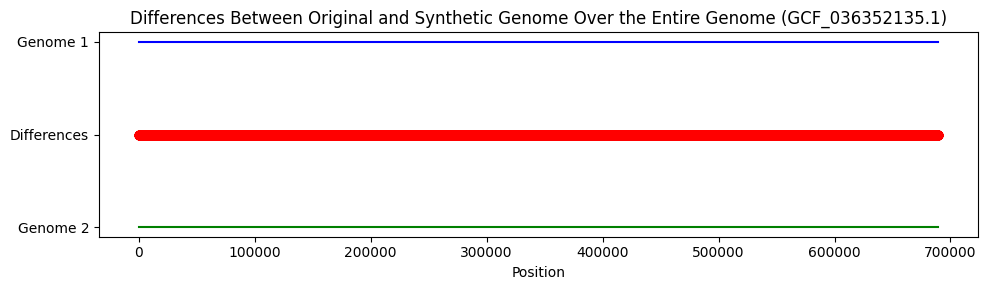

OG: /home/ftoon/Tests/TestingDatasets/ncbi_dataset/data/GCF_028877475.1/GCF_028877475.1_ASM2887747v1_genomic.fna
NG: /home/ftoon/Tests/TestingDatasets/ncbi_dataset/data/GCF_028877475.1/SNP_0.05_GCF_028877475.1_ASM2887747v1_genomic.fna
Genome size: 4698816
Percent Difference: 0.05
Differences found: [2, 25, 72, 96, 98, 107, 127, 145, 154, 163, 173, 196]


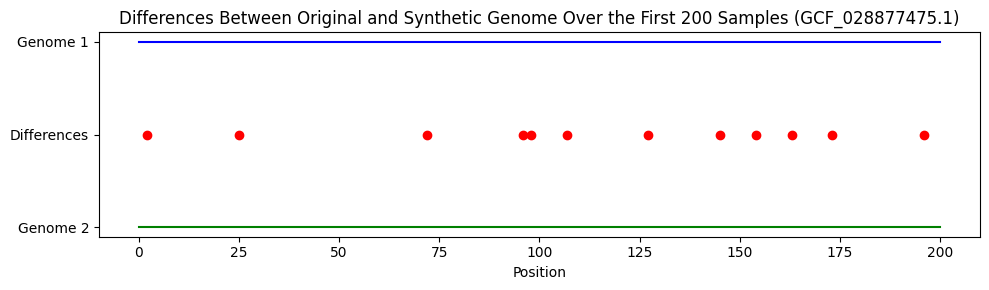

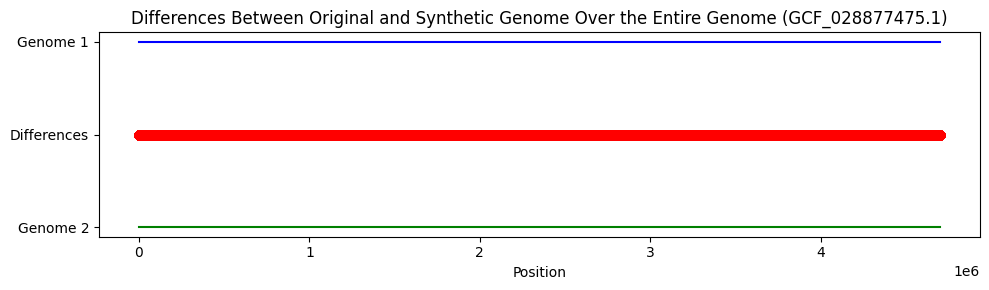

OG: /home/ftoon/Tests/TestingDatasets/ncbi_dataset/data/GCF_028609865.1/GCF_028609865.1_ASM2860986v1_genomic.fna
NG: /home/ftoon/Tests/TestingDatasets/ncbi_dataset/data/GCF_028609865.1/SNP_0.05_GCF_028609865.1_ASM2860986v1_genomic.fna
Genome size: 2567696
Percent Difference: 0.05
Differences found: [2, 41, 87, 104, 144, 147, 170]


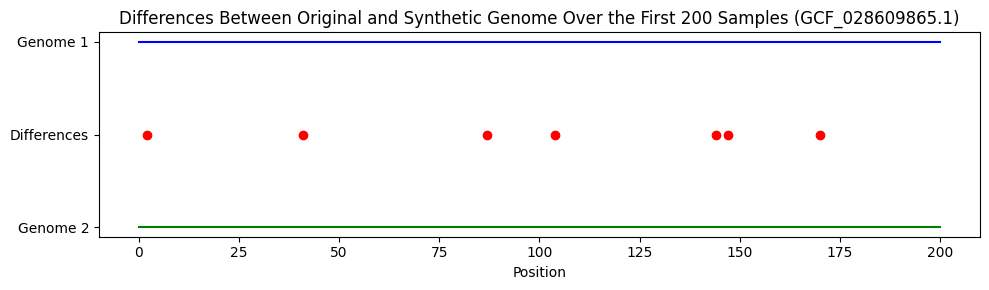

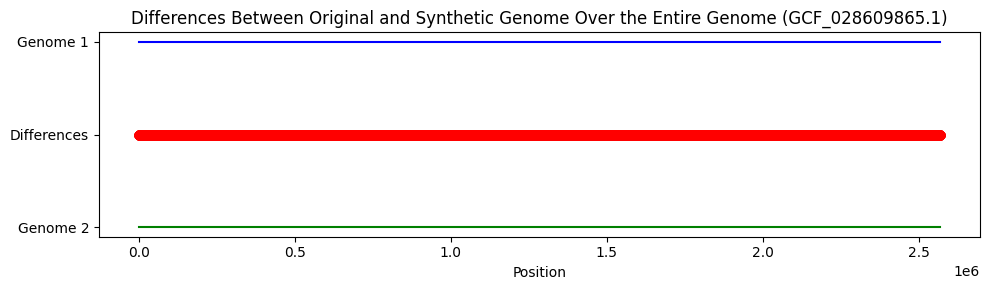

In [16]:
# Locations of SNPs in the genome (Should be uniform at 5%)
for i in range(5):
    file_paths = [original_genomes[i], new_genomes[i]]

    print(f"OG: {original_genomes[i]}\nNG: {new_genomes[i]}")
    # Initialize an empty list to hold the content of each file
    contents = []

    # Process each file in the file_paths list
    for file_path in file_paths:
        with open(file_path, "r") as file:
            # Read all lines from the file
            lines = file.readlines()

            # Initialize an empty string to hold the content of the current file
            content = ""

            # Process each line, skipping the first line
            for line in lines[1:]:
                # Remove newline characters and concatenate to the content string
                content += line.strip()
            
            # Append the processed content to the contents list
            contents.append(content)

    # Check genomes are same size
    if len(contents[0]) != len(contents[1]):
        print("Genomes are not the same size")

    print(f"Genome size: {len(contents[0])}")

    # Find the differences between the two content strings
    differences = []
    #for i in range(len(contents[0])):
    for i in range(200):
        if contents[0][i] != contents[1][i]:
            differences.append(i)

    long_diff = []
    for i in range(len(contents[0])):
        if contents[0][i] != contents[1][i]:
            long_diff.append(i)

    print(f"Percent Difference: {round(len(long_diff) / len(contents[0]), 5)}")
    print(f"Differences found: {differences}")

    # Plot the differences (200 nucleotides)
    fig, ax = plt.subplots(figsize=(10, 3))

    match = re.search(r'(GCF_\d+\.\d+)', file_paths[0])
    name = str(match.group(1))

    # Scatter plot of differences
    ax.scatter(differences, [1] * len(differences), color='r', label="Differences")

    # Draw lines for the two genomes
    #ax.plot([0, len(contents[0])], [2, 2], label="Genome 1", color='b')
    #ax.plot([0, len(contents[0])], [0, 0], label="Genome 2", color='g')
    ax.plot([0, 200], [2, 2], label="Genome 1", color='b')
    ax.plot([0, 200], [0, 0], label="Genome 2", color='g')

    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(['Genome 2', 'Differences', 'Genome 1'])
    ax.set_xlabel("Position")
    ax.set_title("Differences Between Original and Synthetic Genome Over the First 200 Samples (" + str(name) + ")")
    #ax.legend()

    # Display the plot
    #ax.legend(loc='lower center')
    plt.tight_layout()
    plt.show()

    # Plot the differences (Full genome)
    fig, ax = plt.subplots(figsize=(10, 3))

    # Scatter plot of differences
    ax.scatter(long_diff, [1] * len(long_diff), color='r', label="Differences")

    # Draw lines for the two genomes
    ax.plot([0, len(contents[0])], [2, 2], label="Genome 1", color='b')
    ax.plot([0, len(contents[0])], [0, 0], label="Genome 2", color='g')

    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(['Genome 2', 'Differences', 'Genome 1'])
    ax.set_xlabel("Position")
    ax.set_title("Differences Between Original and Synthetic Genome Over the Entire Genome (" + str(name) + ")")
    #ax.legend()

    # Display the plot
    #ax.legend(loc='lower center')
    plt.tight_layout()
    plt.show()

In [41]:
# Running ANI Tests
for i in range(len(directories)):
    file_paths = [original_genomes[i], new_genomes[i]]

    #print(f"{i}\nDr: {directories[i]}\nOG: {original_genomes[i]}\nNG: {new_genomes[i]}")


    # Process each file in the file_paths list
    command = f'cd {directories[i]} && /opt/FastANI-v1.34/fastANI -r {file_paths[0]} -q {file_paths[1]} -o {directories[i]}/fastani.txt'
    try:
        # Run the command in the shell with a timeout of 3 minutes
        result = subprocess.run(command, shell=True, timeout=3*60, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, universal_newlines=True)

        # Print stderr output
        if result.stderr:
            print(result.stderr)
                
    except subprocess.TimeoutExpired as e:
        print(f"Command timed out: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")


In [14]:
# Arrays to store ANI values and other related information
ani_values_array = []

for file_path in directories:
    fastani_file = os.path.join(file_path, "fastani.txt")
    if not os.path.isfile(fastani_file):
        print(f"The file at {fastani_file} does not exist.")
        continue

    try:
        with open(fastani_file, 'r') as file:
            for line in file:
                parts = line.strip().split('\t')
                if len(parts) >= 3:
                    try:
                        ani_value = float(parts[2])
                        ani_values_array.append(ani_value)
                    except ValueError:
                        print(f"Could not convert ANI value to float: {parts[2]}")
                
    except Exception as e:
        print(f"An error occurred while processing the file {fastani_file}: {e}")

print(f"ANI values array length: {len(ani_values_array)}")
if ani_values_array:
    print(f"First ANI value: {ani_values_array[0]}")

ANI values array length: 540
First ANI value: 94.142


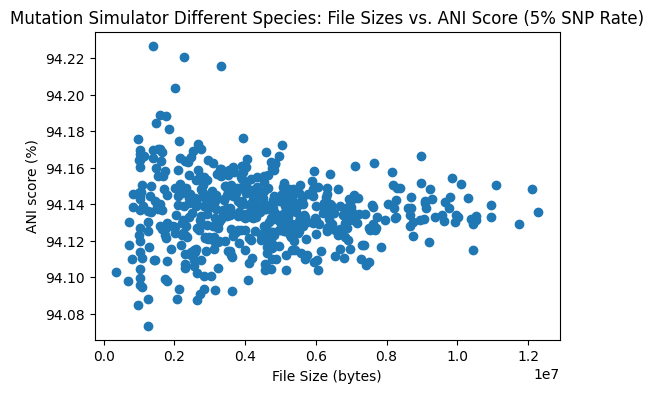

In [15]:
# Plotting time against genome size
# Convert file paths to a simple numeric index for x-axis
x = file_sizes
y = ani_values_array

plt.figure(figsize=(6, 4))  # Set the figure size (width, height)
plt.scatter(x, y)
plt.title('Mutation Simulator Different Species: File Sizes vs. ANI Score (5% SNP Rate)')
plt.xlabel('File Size (bytes)')
plt.ylabel('ANI score (%)')
plt.show()

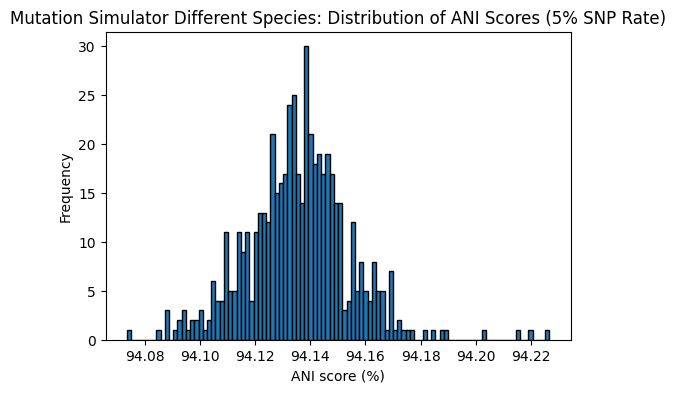

In [16]:
# Your existing data
x = file_sizes
y = ani_values_array

plt.figure(figsize=(6, 4))  # Set the figure size (width, height)

# Create a histogram of the ANI scores
plt.hist(y, bins=100, edgecolor='black')  # Adjust the number of bins as needed
plt.title('Mutation Simulator Different Species: Distribution of ANI Scores (5% SNP Rate)')
plt.xlabel('ANI score (%)')
plt.ylabel('Frequency')
plt.show()


In [17]:
y = numpy.array(ani_values_array)
ani_mean = numpy.mean(y)
ani_median = numpy.median(y)
ani_std = numpy.std(y)
ani_min = numpy.min(y)
ani_max = numpy.max(y)
ani_range = ani_max - ani_min
print("ANI Scores Statistics:")
print(f"Mean: {ani_mean}")
print(f"Median: {ani_median}")
print(f"Standard Deviation: {ani_std}")
print(f"Min: {ani_min}")
print(f"Max: {ani_max}")
print(f"Range: {ani_range}")

ANI Scores Statistics:
Mean: 94.13566851851851
Median: 94.1357
Standard Deviation: 0.018905365925264803
Min: 94.0733
Max: 94.2268
Range: 0.15349999999999397


In [50]:
# Create simulations at different rates
index = 0
rate = [0.06,0.07,0.08,0.09,0.10] # Already have done 0.05
for SNP_rate in rate:
    if directories and file_names:
        count = 0  # Counter for directories processed
        for first_directory, first_fna_file in zip(directories, file_names):
            if count >= 10:  # Check if 10 directories have been processed
                break

            index = index + 1
            print(f'{index}: {SNP_rate}) {first_directory} -> {first_fna_file}')

            # Build the command to change directory and show the first 10 lines of the .fna file
            command = f'cd {first_directory} && (/usr/bin/time -v mutation-simulator {first_fna_file} args -sn {SNP_rate} && mv $(find . -name "*.fna" | grep -vi "_gen" | grep -vi "SNP") SNP_{SNP_rate}_{first_fna_file} && mv $(find . -name "*.fna.fai" | grep -vi "SNP") SNP_{SNP_rate}_{first_fna_file}.fai) > stats.txt 2>&1'

            try:
                # Run the command in the shell with a timeout of 3 minutes
                result = subprocess.run(command, shell=True, timeout=3*60, stderr=subprocess.PIPE, universal_newlines=True)

                # Print stderr output
                if result.stderr:
                    print(result.stderr)
                
            except subprocess.TimeoutExpired as e:
                print(f"Command timed out: {e}")
            except Exception as e:
                print(f"An error occurred: {e}")

            count += 1  # Increment the counter after processing a directory
    else:
        print("No .fna files found.")
print("Done")


1: 0.06) /home/ftoon/Tests/TestingDatasets/ncbi_dataset/data/GCF_032850805.1 -> GCF_032850805.1_ASM3285080v1_genomic.fna
2: 0.06) /home/ftoon/Tests/TestingDatasets/ncbi_dataset/data/GCF_028885435.1 -> GCF_028885435.1_ASM2888543v1_genomic.fna
3: 0.06) /home/ftoon/Tests/TestingDatasets/ncbi_dataset/data/GCF_036352135.1 -> GCF_036352135.1_ASM3635213v1_genomic.fna
4: 0.06) /home/ftoon/Tests/TestingDatasets/ncbi_dataset/data/GCF_028877475.1 -> GCF_028877475.1_ASM2887747v1_genomic.fna
5: 0.06) /home/ftoon/Tests/TestingDatasets/ncbi_dataset/data/GCF_028609865.1 -> GCF_028609865.1_ASM2860986v1_genomic.fna
6: 0.06) /home/ftoon/Tests/TestingDatasets/ncbi_dataset/data/GCF_964019765.1 -> GCF_964019765.1_ijPanGerm4.Spiroplasma_sp_1.1_genomic.fna
7: 0.06) /home/ftoon/Tests/TestingDatasets/ncbi_dataset/data/GCF_029892045.1 -> GCF_029892045.1_ASM2989204v1_genomic.fna
8: 0.06) /home/ftoon/Tests/TestingDatasets/ncbi_dataset/data/GCF_029714545.1 -> GCF_029714545.1_ASM2971454v1_genomic.fna
9: 0.06) /home/

In [18]:
# Get paths of new genomes
# See if there has been a 5% change in each, get length of orginal, length of change and difference value between them.ls
ani_genomes = []
end_pattern = ".fna"
mod_patterns = ["SNP_0.01", "SNP_0.02", "SNP_0.03", "SNP_0.04", "SNP_0.05", "SNP_0.06", "SNP_0.07", "SNP_0.08", "SNP_0.09", "SNP_0.1"]
bad_pattern = ".fai"

directory_count = 0
for root, dirs, files in os.walk(start_directory):
    if directory_count > 10:  # Stop after checking 10 directories
        break
    
    for file in files:
        if end_pattern in file and any(mod_pattern in file for mod_pattern in mod_patterns) and bad_pattern not in file:
            ani_genomes.append(os.path.join(root, file))

    directory_count += 1

print(len(ani_genomes))

100


In [32]:
# Dont remember why this is here \_(._.)_/ <- I do remember, it runs the new ANI tests against the new SNP rates

# Extract the SNP_0.01 pattern 
for file_path in ani_genomes:

    # Figure out which number it is
    snp_pattern = re.search(r'SNP_\d+\.\d+', file_path)
    if snp_pattern:
        snp_full = snp_pattern.group(0)
    
        # Extract the numeric value from the SNP_0.01 pattern
        snp_value = re.search(r'\d+\.\d+', snp_full)
        if snp_value:
            snp_numeric = snp_value.group(0)

    # Get the OG dir
    og_dir = re.split(r'SNP_', file_path)[0]

    # Get the OG file
    matching_path = None
    for path in original_genomes:
        if path.startswith(og_dir):
            matching_path = path
            break

    command = f'cd {og_dir} && /opt/FastANI-v1.34/fastANI -r {matching_path} -q {file_path} -o {og_dir}/{snp_numeric}_fastani.txt'
    try:
        # Run the command in the shell with a timeout of 3 minutes
        result = subprocess.run(command, shell=True, timeout=3*60, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, universal_newlines=True)

        # Print stderr output
        if result.stderr:
            print(result.stderr)
                
    except subprocess.TimeoutExpired as e:
        print(f"Command timed out: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")

    

In [19]:
# Get the first ten directories
dir_ten = directories[0:10]

# List to store ANI values
ani_test_results = []

for folder in dir_ten:
    try:
        for root, _, files in os.walk(folder):
            for file in files:
                if '_fastani' in file:
                    if file[0:4] == "0.1_":
                        file_id = float(file[0:3])
                    else:
                        file_id = float(file[0:4])
                    file_path = os.path.join(root, file)
                    # Open and read the file
                    with open(file_path, 'r') as f:
                        for line in f:
                            parts = line.strip().split('\t')
                            if len(parts) >= 3:
                                try:
                                    ani_value = float(parts[2])
                                    ani_test_results.append([folder[52:], file_id, ani_value])
                                except ValueError:
                                    print(f"Could not convert ANI value to float: {parts[2]}")
    except Exception as e:
        print(f"An error occurred while processing files in folder {folder}: {e}")


print(len(ani_test_results))

100


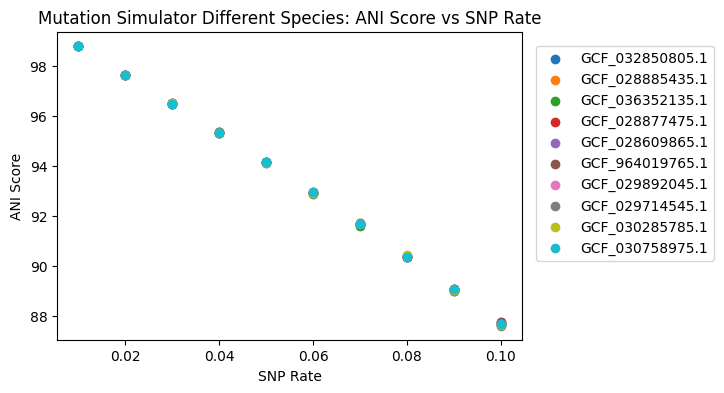

In [23]:
# Create a dictionary to store data by legend
data_dict = {}
for entry in ani_test_results:
    legend, x, y = entry
    if legend not in data_dict:
        data_dict[legend] = {'x': [], 'y': []}
    data_dict[legend]['x'].append(x)
    data_dict[legend]['y'].append(y)

# Plotting
plt.figure(figsize=(6, 4))

for legend, values in data_dict.items():
    # Scatter plot
    plt.scatter(values['x'], values['y'], label=legend)
    # Line plot to connect the dots
    #plt.plot(values['x'], values['y'], linestyle='-', marker='o')

plt.xlabel('SNP Rate')
plt.ylabel('ANI Score')
# Adjust the legend to be outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=1)
plt.title('Mutation Simulator Different Species: ANI Score vs SNP Rate')
plt.show()

In [181]:
# Modifications to just the genes at a rate of 0.005%, not sure yet why the rate of snps has to be so small but it any higher and then it throughs a error
# saying that you are trying to make to many modifications to the genome

index = 0
rate = [0.005]
for SNP_rate in rate:
    if directories and file_names:
        for first_directory, first_fna_file in zip(directories, file_names):
            index = index + 1
            print(f'{index}: {first_directory} -> {first_fna_file}')

            # Build the command to change directory and show the first 10 lines of the .fna fil
            command = f'cd {first_directory} && /Users/frasertoon/Documents/Uni/EGH400-2/Testing/gff_genes_2_rmt.py genomic.gff {SNP_rate} && time mutation-simulator {first_fna_file} rmt genomic.rmt > stats_just_genes.txt && mv $(find . -name "*.fna" | grep -vi "_gen" | grep -vi "SNP" | grep -vi "TIVI") SNP_{SNP_rate}_JustGenes_{first_fna_file} && mv $(find . -name "*.fna.fai" | grep -vi "SNP" | grep -vi "TITV") SNP_{SNP_rate}_JustGenes.fai'

            try:
                # Run the command in the shell with a timeout of 3 minutes
                result = subprocess.run(command, shell=True, timeout=3*60, stderr=subprocess.PIPE, universal_newlines=True)

                # Print stderr output
                if result.stderr:
                    print(result.stderr)
                
            except subprocess.TimeoutExpired as e:
                print(f"Command timed out: {e}")
            except Exception as e:
                print(f"An error occurred: {e}")
    else:
        print("No .fna files found.")

print("Done")

1: /Users/frasertoon/Documents/Uni/EGH400-2/Testing/TestingDatasets/ncbi_dataset/data/GCF_037060685.1 -> GCF_037060685.1_ASM3706068v1_genomic.fna
ERROR: A range definition of chromosome 1 is longer than the chromosome. Occurred while reading genomic.rmt

real	0m0.112s
user	0m0.539s
sys	0m0.015s

2: /Users/frasertoon/Documents/Uni/EGH400-2/Testing/TestingDatasets/ncbi_dataset/data/GCF_030845235.1 -> GCF_030845235.1_ASM3084523v1_genomic.fna

real	0m7.607s
user	0m8.018s
sys	0m0.039s

3: /Users/frasertoon/Documents/Uni/EGH400-2/Testing/TestingDatasets/ncbi_dataset/data/GCF_036840915.1 -> GCF_036840915.1_ASM3684091v1_genomic.fna

real	0m2.678s
user	0m2.834s
sys	0m0.196s

4: /Users/frasertoon/Documents/Uni/EGH400-2/Testing/TestingDatasets/ncbi_dataset/data/GCF_030252185.1 -> GCF_030252185.1_ASM3025218v1_genomic.fna
ERROR: A range definition of chromosome 1 is longer than the chromosome. Occurred while reading genomic.rmt

real	0m0.109s
user	0m0.497s
sys	0m0.019s

5: /Users/frasertoon/Documen

In [184]:
# Find how many worked

new_gene_genomes = []
end_pattern = ".fna"
mod_patterns = ["0.005_JustGenes"]
bad_pattern = ".fai"

# Traverse the directory tree
for root, dirs, files in os.walk(start_directory):
    for file in files:
        if end_pattern in file and any(mod_pattern in file for mod_pattern in mod_patterns) and bad_pattern not in file:
            new_gene_genomes.append(str(root) + "/" + str(file))


print(f"Done: {len(new_gene_genomes)}")

Done: 311


OG: /Users/frasertoon/Documents/Uni/EGH400-2/Testing/TestingDatasets/ncbi_dataset/data/GCF_030845235.1/GCF_030845235.1_ASM3084523v1_genomic.fna
NG: /Users/frasertoon/Documents/Uni/EGH400-2/Testing/TestingDatasets/ncbi_dataset/data/GCF_030845235.1/SNP_0.005_JustGenes_GCF_030845235.1_ASM3084523v1_genomic.fna
Genome size: 10326501
Percent Difference: 0.26442
Differences found: []


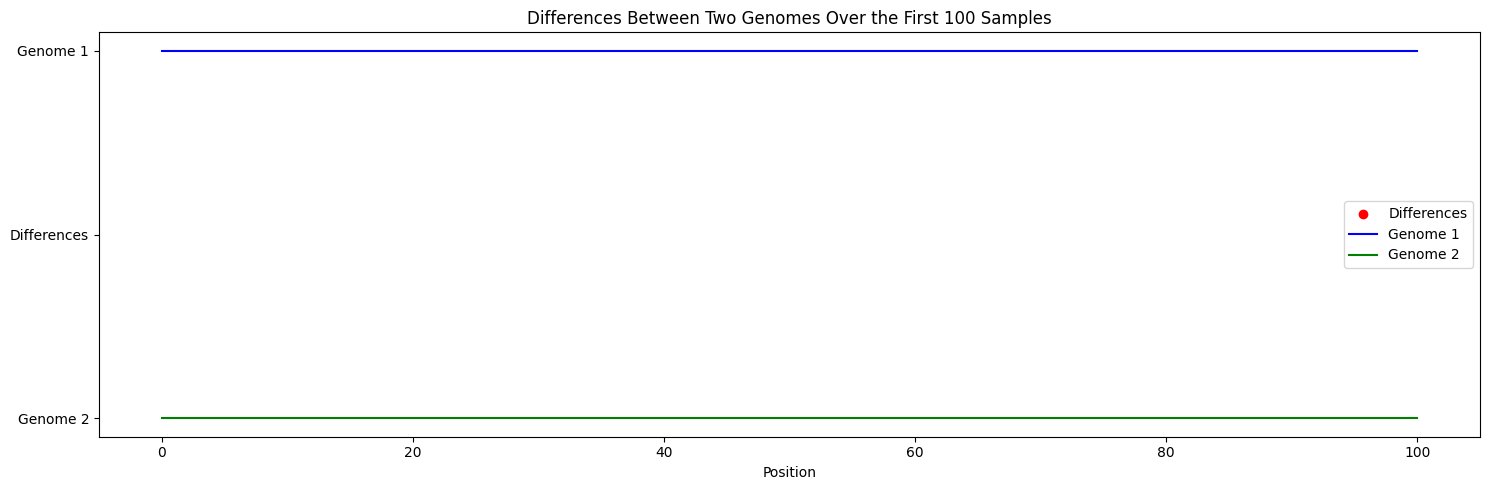

OG: /Users/frasertoon/Documents/Uni/EGH400-2/Testing/TestingDatasets/ncbi_dataset/data/GCF_030845235.1/GCF_030845235.1_ASM3084523v1_genomic.fna
NG: /Users/frasertoon/Documents/Uni/EGH400-2/Testing/TestingDatasets/ncbi_dataset/data/GCF_036840915.1/SNP_0.005_JustGenes_GCF_036840915.1_ASM3684091v1_genomic.fna
Genomes are not the same size: OG: 10326501, NG: 3465871
Genome size: 10326501
Percent Difference: 0.26442
Differences found: [1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 28, 29, 30, 31, 34, 36, 37, 38, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 55, 56, 58, 59, 60, 61, 62, 63, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 98, 99, 101, 103, 104, 105, 106, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 120, 121, 122, 123, 124, 126, 128, 129, 130, 132, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 157, 158, 159, 160, 161, 162, 16

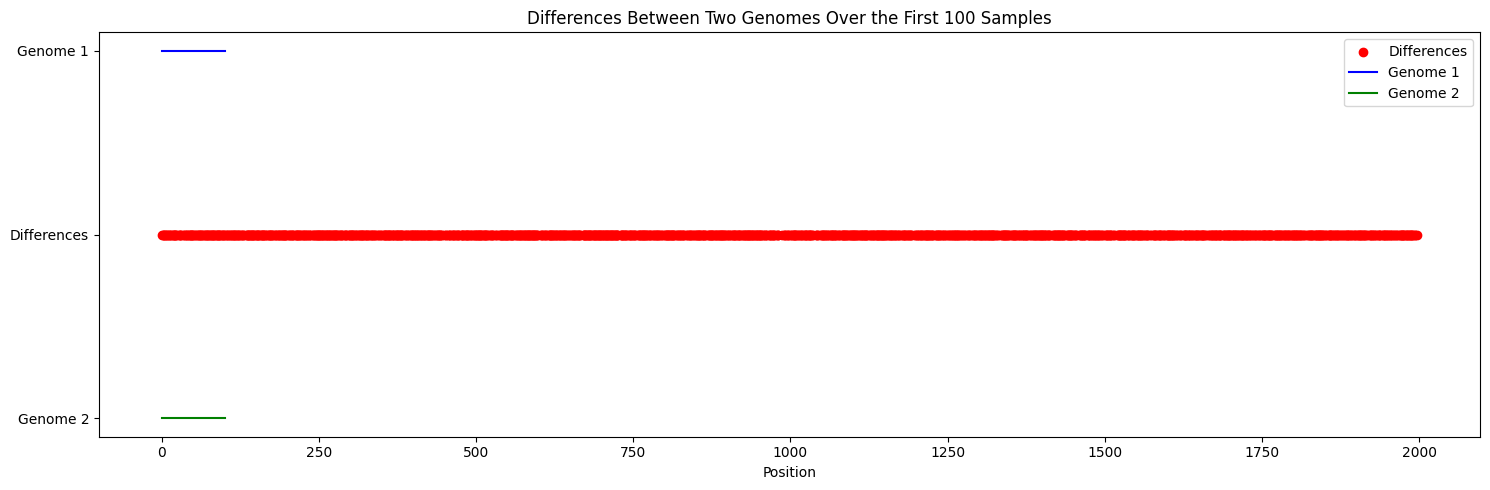

OG: /Users/frasertoon/Documents/Uni/EGH400-2/Testing/TestingDatasets/ncbi_dataset/data/GCF_030845235.1/GCF_030845235.1_ASM3084523v1_genomic.fna
NG: /Users/frasertoon/Documents/Uni/EGH400-2/Testing/TestingDatasets/ncbi_dataset/data/GCF_036320555.1/SNP_0.005_JustGenes_GCF_036320555.1_ASM3632055v1_genomic.fna
Genomes are not the same size: OG: 10326501, NG: 4765196
Genome size: 10326501
Percent Difference: 0.26442
Differences found: [0, 1, 2, 3, 4, 5, 6, 8, 11, 12, 13, 14, 16, 17, 18, 19, 21, 23, 25, 28, 29, 30, 31, 32, 34, 35, 37, 38, 39, 40, 41, 42, 44, 46, 47, 53, 55, 57, 58, 59, 60, 61, 65, 69, 70, 72, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 89, 90, 93, 94, 97, 98, 102, 103, 104, 106, 107, 111, 118, 120, 121, 124, 127, 129, 130, 131, 132, 133, 134, 135, 136, 141, 142, 143, 144, 145, 147, 149, 153, 154, 156, 157, 158, 159, 160, 162, 163, 165, 166, 168, 169, 170, 171, 175, 176, 177, 178, 179, 180, 181, 182, 184, 185, 188, 189, 191, 193, 194, 196, 197, 198, 199, 200, 201, 202, 203, 2

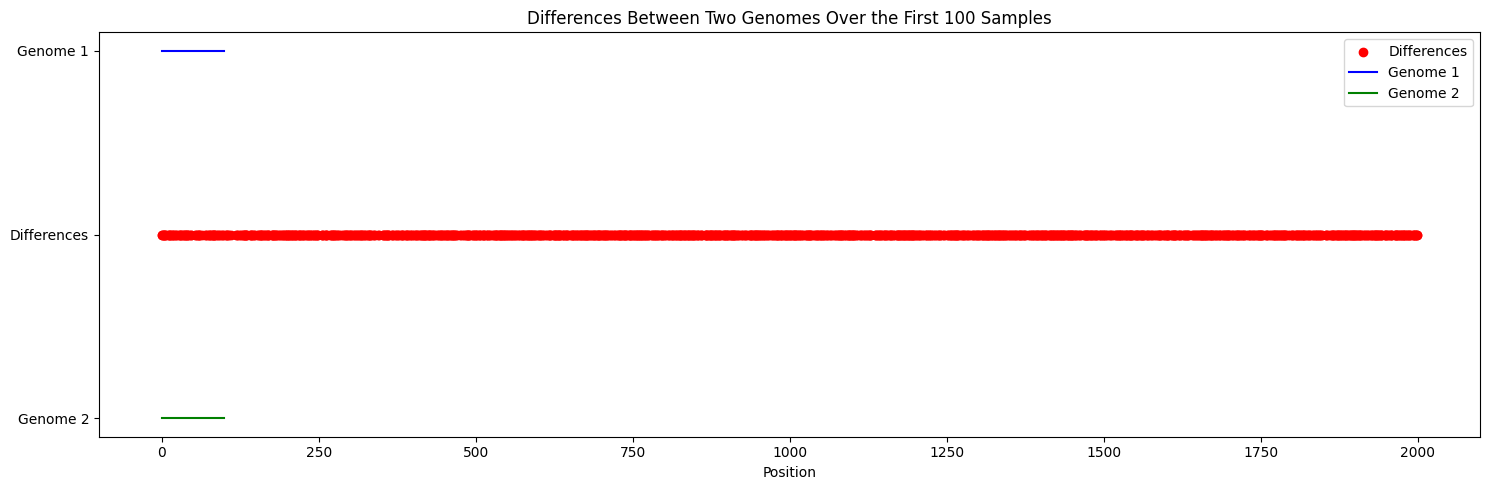

OG: /Users/frasertoon/Documents/Uni/EGH400-2/Testing/TestingDatasets/ncbi_dataset/data/GCF_030845235.1/GCF_030845235.1_ASM3084523v1_genomic.fna
NG: /Users/frasertoon/Documents/Uni/EGH400-2/Testing/TestingDatasets/ncbi_dataset/data/GCF_030295865.1/SNP_0.005_JustGenes_GCF_030295865.1_ASM3029586v1_genomic.fna
Genomes are not the same size: OG: 10326501, NG: 719195
Genome size: 10326501
Percent Difference: 0.26442
Differences found: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 39, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 86, 87, 88, 90, 92, 93, 95, 96, 97, 98, 99, 101, 102, 104, 106, 108, 110, 111, 113, 114, 116, 118, 120, 121, 122, 123, 125, 126, 127, 128, 129, 130, 131, 132, 134, 135, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 148, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163

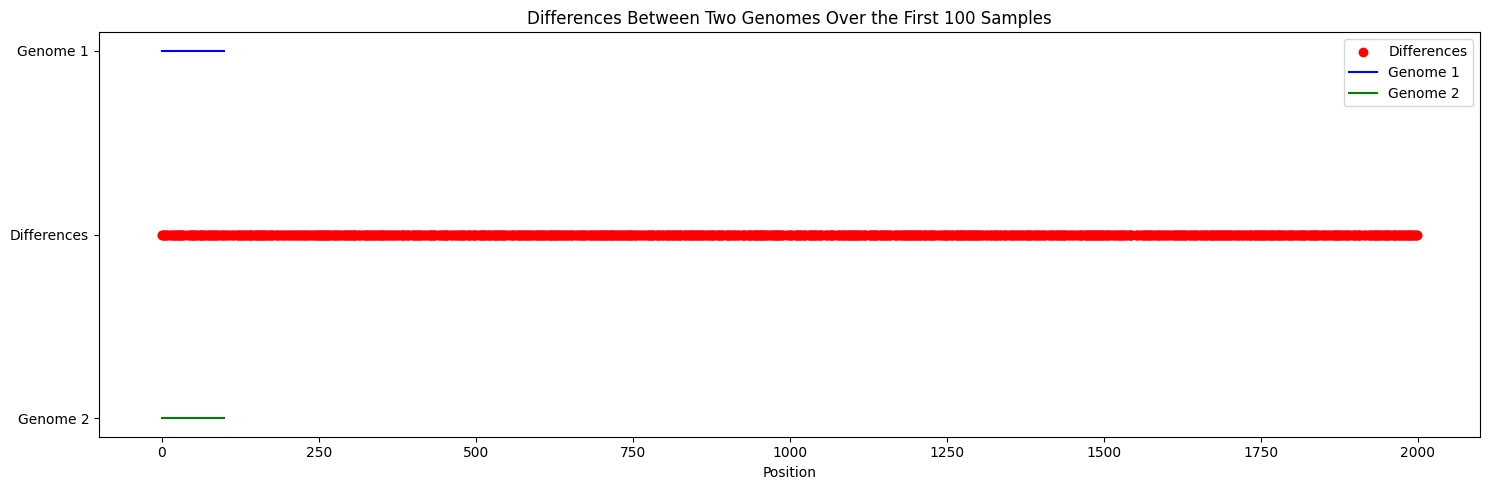

OG: /Users/frasertoon/Documents/Uni/EGH400-2/Testing/TestingDatasets/ncbi_dataset/data/GCF_030845235.1/GCF_030845235.1_ASM3084523v1_genomic.fna
NG: /Users/frasertoon/Documents/Uni/EGH400-2/Testing/TestingDatasets/ncbi_dataset/data/GCF_037414505.1/SNP_0.005_JustGenes_GCF_037414505.1_Str_netropsis_B-235_v1_genomic.fna
Genomes are not the same size: OG: 10326501, NG: 8144008
Genome size: 10326501
Percent Difference: 0.26442
Differences found: [0, 1, 3, 4, 5, 6, 8, 10, 11, 12, 14, 15, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 35, 36, 38, 39, 40, 42, 43, 44, 45, 49, 50, 51, 52, 55, 56, 57, 58, 60, 61, 63, 64, 65, 66, 67, 69, 70, 72, 73, 74, 75, 76, 77, 78, 82, 83, 84, 88, 89, 90, 91, 93, 94, 96, 97, 98, 99, 100, 101, 103, 104, 106, 107, 109, 110, 112, 113, 114, 115, 117, 118, 119, 121, 123, 124, 125, 126, 127, 128, 129, 130, 133, 134, 135, 137, 138, 140, 141, 143, 144, 145, 146, 147, 151, 152, 153, 157, 159, 160, 161, 162, 164, 165, 166, 167, 169, 170, 171, 172, 175, 176, 177, 178

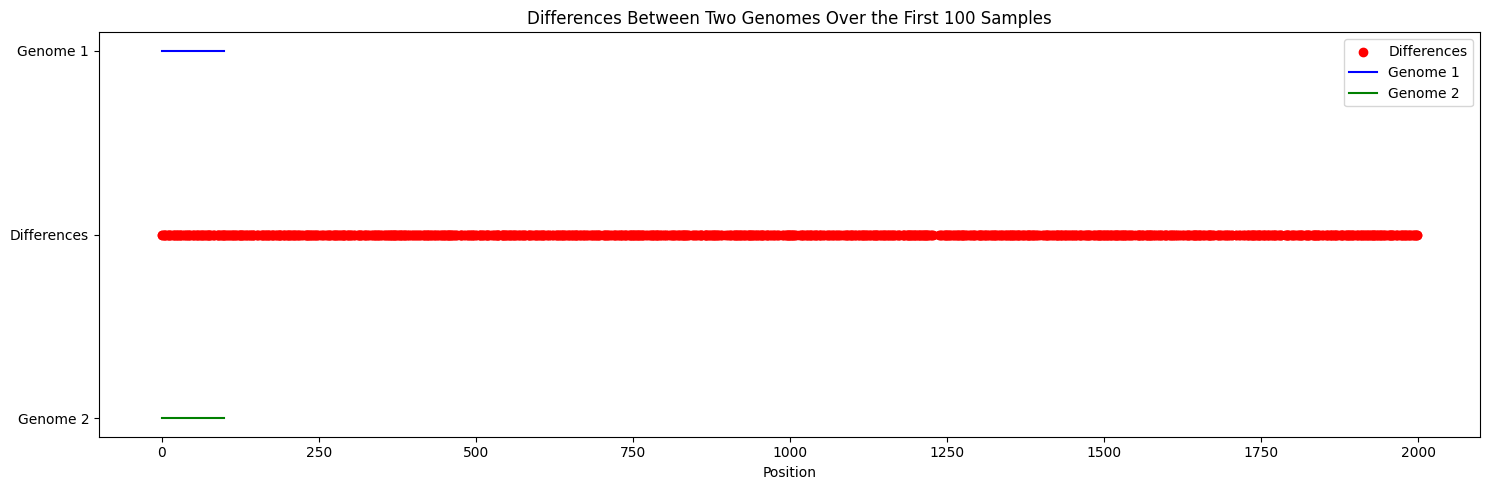

In [198]:
# Locations of SNPs in the genome (Should be uniform at 5%) (TITV Test)
for i in range(5):
    match_index = 0
    
    index_gcf = new_gene_genomes[0].find("SNP")
    match_string = new_gene_genomes[0][:index_gcf]

    found = False
    while found == False:
        if match_string in original_genomes[match_index]:
            found = True
        else:
            match_index += 1

    file_paths = [original_genomes[match_index], new_gene_genomes[i]]

    print(f"OG: {original_genomes[match_index]}\nNG: {new_gene_genomes[i]}")
    # Initialize an empty list to hold the content of each file
    contents = []

    # Process each file in the file_paths list
    for file_path in file_paths:
        with open(file_path, "r") as file:
            # Read all lines from the file
            lines = file.readlines()

            # Initialize an empty string to hold the content of the current file
            content = ""

            # Process each line, skipping the first line
            for line in lines[1:]:
                # Remove newline characters and concatenate to the content string
                content += line.strip()
            
            # Append the processed content to the contents list
            contents.append(content)

    # Check genomes are same size
    if len(contents[0]) != len(contents[1]):
        print(f"Genomes are not the same size: OG: {len(contents[0])}, NG: {len(contents[1])}")

    print(f"Genome size: {len(contents[0])}")

    # Find the differences between the two content strings
    differences = []
    #for i in range(len(contents[0])):
    for i in range(500):
        if contents[0][i] != contents[1][i]:
            differences.append(i)

    # long_diff = []
    # for i in range(len(contents[0])):
    #     if contents[0][i] != contents[1][i]:
    #         long_diff.append(i)

    print(f"Percent Difference: {round(len(long_diff) / len(contents[0]), 5)}")
    print(f"Differences found: {differences}")

    # Plot the differences
    fig, ax = plt.subplots(figsize=(15, 5))

    # Scatter plot of differences
    ax.scatter(differences, [1] * len(differences), color='r', label="Differences")

    # Draw lines for the two genomes
    #ax.plot([0, len(contents[0])], [2, 2], label="Genome 1", color='b')
    #ax.plot([0, len(contents[0])], [0, 0], label="Genome 2", color='g')
    ax.plot([0, 500], [2, 2], label="Genome 1", color='b')
    ax.plot([0, 500], [0, 0], label="Genome 2", color='g')

    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(['Genome 2', 'Differences', 'Genome 1'])
    ax.set_xlabel("Position")
    ax.set_title("Differences Between Two Genomes Over the First 100 Samples")
    ax.legend()

    # Display the plot
    plt.tight_layout()
    plt.show()